In [1]:
import warnings
import numpy as np
import gc
import json
import h5py
import threading
import time
import seaborn as sn
import pandas as pd

import tensorflow as tf
from keras.utils import Sequence
from keras.utils.data_utils import get_file
from keras.preprocessing import sequence
from keras.preprocessing.sequence import _remove_long_seq
from keras.models import Sequential
from keras.layers import Embedding, Input, Dense, Dropout, CuDNNLSTM, Bidirectional
from keras import metrics
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

# training on 1080 Ti, you may want to adjust these for your own hardware
gpu_options = tf.GPUOptions(
    per_process_gpu_memory_fraction=0.65, allow_growth=False)
config = tf.ConfigProto(intra_op_parallelism_threads=16,
                        inter_op_parallelism_threads=16, allow_soft_placement=True, gpu_options=gpu_options)
session = tf.Session(config=config)
K.set_session(session)


Using TensorFlow backend.


In [2]:
def load_vocab():
    with open('data/ams_word_nomath_index.json') as json_data:
        return json.load(json_data)

    
def load_glove():
    glove = {}
    with open('data/glove.model.nomath.txt') as glove_data:
        for line in glove_data:
            items = line.split()
            key = items[0]
            glove[key] = np.asarray(items[1:], dtype='float32')
    return glove


def build_embedding_layer(with_input=False, maxlen=480, vocab_dim=300, mask_zero=True):
    print("-- loading word embeddings, this may take a couple of minutes...")
    index_dict = load_vocab()
    word_vectors = load_glove()
    # adding 1 to account for 0th index (for masking)
    n_symbols = len(index_dict) + 1
    print("-- known dictionary items: ", n_symbols)
    embedding_weights = np.zeros((n_symbols, vocab_dim))
    for word, index in index_dict.items():
        embedding_weights[index, :] = word_vectors[word]
    print("-- embeddings ")
    if not with_input:
        embedding_layer = Embedding(
            mask_zero=mask_zero,
            output_dim=vocab_dim, input_dim=n_symbols, input_length=maxlen, trainable=False, weights=[embedding_weights])
        return embedding_layer
    else:
        # define inputs here
        input_1 = Input(shape=(maxlen,), dtype='int32')
        embedding_layer = Embedding(
            weights=[embedding_weights],
            mask_zero=mask_zero,
            output_dim=vocab_dim, input_dim=n_symbols, input_length=maxlen, trainable=False)(input_1)
        return (embedding_layer, input_1)


In [3]:
# Input data is obtained via batch loading from HDF5
class DataGenerator(Sequence):
    def __init__(self, batch_size=128, mode="train", dim=480,
             n_classes=49, x_hf = None, y_hf = None, shuffle=True):
        'Initialization'
        self.x_hf = x_hf
        self.y_hf = y_hf
        self.mode = mode
        self.total_len = self.y_hf.shape[0]
        self.validation_len = int(np.ceil(0.1 * self.total_len))
        self.training_len = self.total_len - self.validation_len
        if self.mode == "validation":
            self.data_len = self.validation_len
            self.list_IDs = np.arange(self.training_len, self.total_len)
        else:
            self.data_len = self.training_len
            self.list_IDs = np.arange(0,self.training_len+1)
            
        self.dim = dim
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end() 

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples,  dim)
        # Initialization
        X = np.empty((self.batch_size, self.dim), dtype=int)
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self.x_hf[ID]
            # Store class
            y[i] = self.y_hf[ID]
        
        return X, y
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

batch_size = 128
# Parameters
data_hf = h5py.File("data/nomath_ams.hdf5", 'r')
generator_params = {
    'batch_size': batch_size,
    'n_classes': 50,
    'shuffle': False,
    'x_hf': data_hf['x_train'],
    'y_hf': data_hf['y_train']
}
# Generators
training_generator = DataGenerator(**generator_params)
validation_generator = DataGenerator(mode="validation", **generator_params)


In [9]:
# It takes 10 minutes to recompute, memoizing here for the v5 50 class variant:
# class_weights = compute_class_weight('balanced', np.unique(training_generator.y_hf), training_generator.y_hf)
# np.set_printoptions(precision=32, suppress=True)
# print(class_weights)
class_weights = [
    0.19670347049064218, 1.2497860929601776, 9010.68,
    5068.5075, 7.539616957976943, 5406.408,
    91.78960950764007,  2.6754241789419857, 628.6520930232558,
    0.7125288957030959, 57.78134663341646, 4.852568214456678,
    277.2516923076923, 93.86125, 0.5034165055263623,
    921.5468181818181, 0.30359604445218136, 8.875574039619131,
    1.73811541552805, 0.7015144267159164, 500.5933333333333,
    81096.12, 14744.74909090909, 1318.6360975609757,
    12476.326153846154, 12.306870020487139, 20274.03,
    0.29460038143674505, 7051.83652173913, 129.54651757188498,
    0.1743916322418461, 3.979396437509201, 12.610188151142902,
    45.92079275198188, 40548.06, 11.25475261952675,
    17.977415207271115, 872.0012903225806, 6.93840862422998,
    0.09669754339524776, 0.26562111969080354, 7.600742302825812,
    7.709123057179524, 0.3191855851884505, 0.8460202804206309,
    284.5477894736842, 1398.2089655172413, 31.017831325301206,
    1725.4493617021276, 0.16727264476685905 ]

# 08.2018 (subformula lexemes)
# Analyzing the arxiv dataset seems to indicate 
#   a maxlen of 960 is needed to fit 99.2% of the data
#   a maxlen of 480 fits 96.03%, and a maxlen of 300 covers 90.0% of paragraphs
maxlen = 480
n_classes = 50
layer_size = 128  # ~maxlen // 4

In [ ]:
# Preparing word embeddings
embedding_layer = build_embedding_layer(maxlen=maxlen, mask_zero=False)

In [10]:
model_file = "nomath_bilstm%d_batch%d_cat%d_gpu" % (
    layer_size, batch_size, n_classes)

# Checkpoints: 1) save best model at epoch end, 2) stop early when metric stops improving
checkpoint = ModelCheckpoint(model_file+"-checkpoint.h5",
                             monitor='val_weighted_sparse_categorical_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

earlystop = EarlyStopping(monitor='val_weighted_sparse_categorical_accuracy',
                          min_delta=0.001,
                          patience=3,
                          restore_best_weights=True,
                          verbose=0, mode='auto')


In [5]:
# BiLSTM Model Setup
print("-- setting up model layout...")
use_dropout = True

model = Sequential()
model.add(embedding_layer)
if use_dropout:
    model.add(Dropout(0.2))

model.add(Bidirectional(CuDNNLSTM(layer_size, return_sequences=True)))
if use_dropout:
    model.add(Dropout(0.2))

model.add(Bidirectional(CuDNNLSTM(layer_size // 2, return_sequences=True)))
if use_dropout:
    model.add(Dropout(0.1))

model.add(CuDNNLSTM(layer_size // 2))
if use_dropout:
    model.add(Dropout(0.1))

model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              weighted_metrics=[metrics.sparse_categorical_accuracy])


-- setting up model layout...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
from keras.models import load_model
resume_filename = model_file+"-checkpoint.h5"
model = load_model(resume_filename)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              weighted_metrics=[metrics.sparse_categorical_accuracy])

In [12]:
# Perform training
# Print model summary
print(model.summary())
print('-- training model...')
# TODO: How can we make this work with more workers? HDF5 is not thread-safe for reads...
# maybe use the unpacked .txt files and map them through the dictionary each time? Unsure... 
# On a single CPU worker: 2.5 hours per epoch for the full data, with the main BiLSTM model.
model.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    workers = 1,
    use_multiprocessing=False,
    class_weight=class_weights,
    epochs=50,
    verbose=1,
    callbacks=[checkpoint, earlystop])

print("-- saving model to disk : %s " % model_file)
model.save(model_file+'_notebook.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 480, 300)          227160900 
_________________________________________________________________
dropout_1 (Dropout)          (None, 480, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 480, 256)          440320    
_________________________________________________________________
dropout_2 (Dropout)          (None, 480, 256)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 480, 128)          164864    
_________________________________________________________________
dropout_3 (Dropout)          (None, 480, 128)          0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 64)                49664     
__________

In [10]:
#from keras.models import load_model
# model = load_model(model_file+"_notebook.h5")

In [13]:
print("Per-class test measures:")
y_pred = model.predict_classes(data_hf['x_test'], verbose=1, batch_size=batch_size)
print(classification_report(data_hf['y_test'], y_pred))

Per-class test measures:
2027375/2027375 [==============================] - 974s 481us/step


/home/deyan/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.92      0.95      0.94    206137
           1       0.99      1.00      0.99     32444
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         7
           4       0.43      0.36      0.39      5378
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00       441
           7       0.39      0.03      0.05     15155
           8       0.00      0.00      0.00        64
           9       0.73      0.73      0.73     56907
          10       0.00      0.00      0.00       701
          11       0.63      0.02      0.03      8355
          12       0.00      0.00      0.00       146
          13       0.18      0.01      0.02       432
          14       0.36      0.04      0.07     80545
          15       0.00      0.00      0.00        43
          16       0.83      0.90      0.86    133559
          17       0.48    

In [14]:
class_names=np.array(sorted([
    "abstract", "acknowledgement", "affirmation", "answer", "assumption",
    "bound", "case", "claim", "comment", "conclusion",
    "condition", "conjecture", "constraint", "convention", "corollary",
    "criterion", "definition", "demonstration", "discussion", "example",
    "exercise", "expansion", "expectation", "experiment", "explanation",
    "fact", "hint", "introduction", "issue", "keywords",
    "lemma", "method", "notation", "note", "notice",
    "observation", "overview", "principle", "problem", "proof",
    "proposition", "question", "related work", "remark", "result", "rule",
    "solution", "step", "summary", "theorem"]))
np.set_printoptions(precision=2)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        annot = True
        print("Normalized confusion matrix")
    else:
        annot = False
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(50,40))
    df_cm = pd.DataFrame(cm, index = classes,
                  columns = classes)
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=annot)

Confusion matrix, without normalization


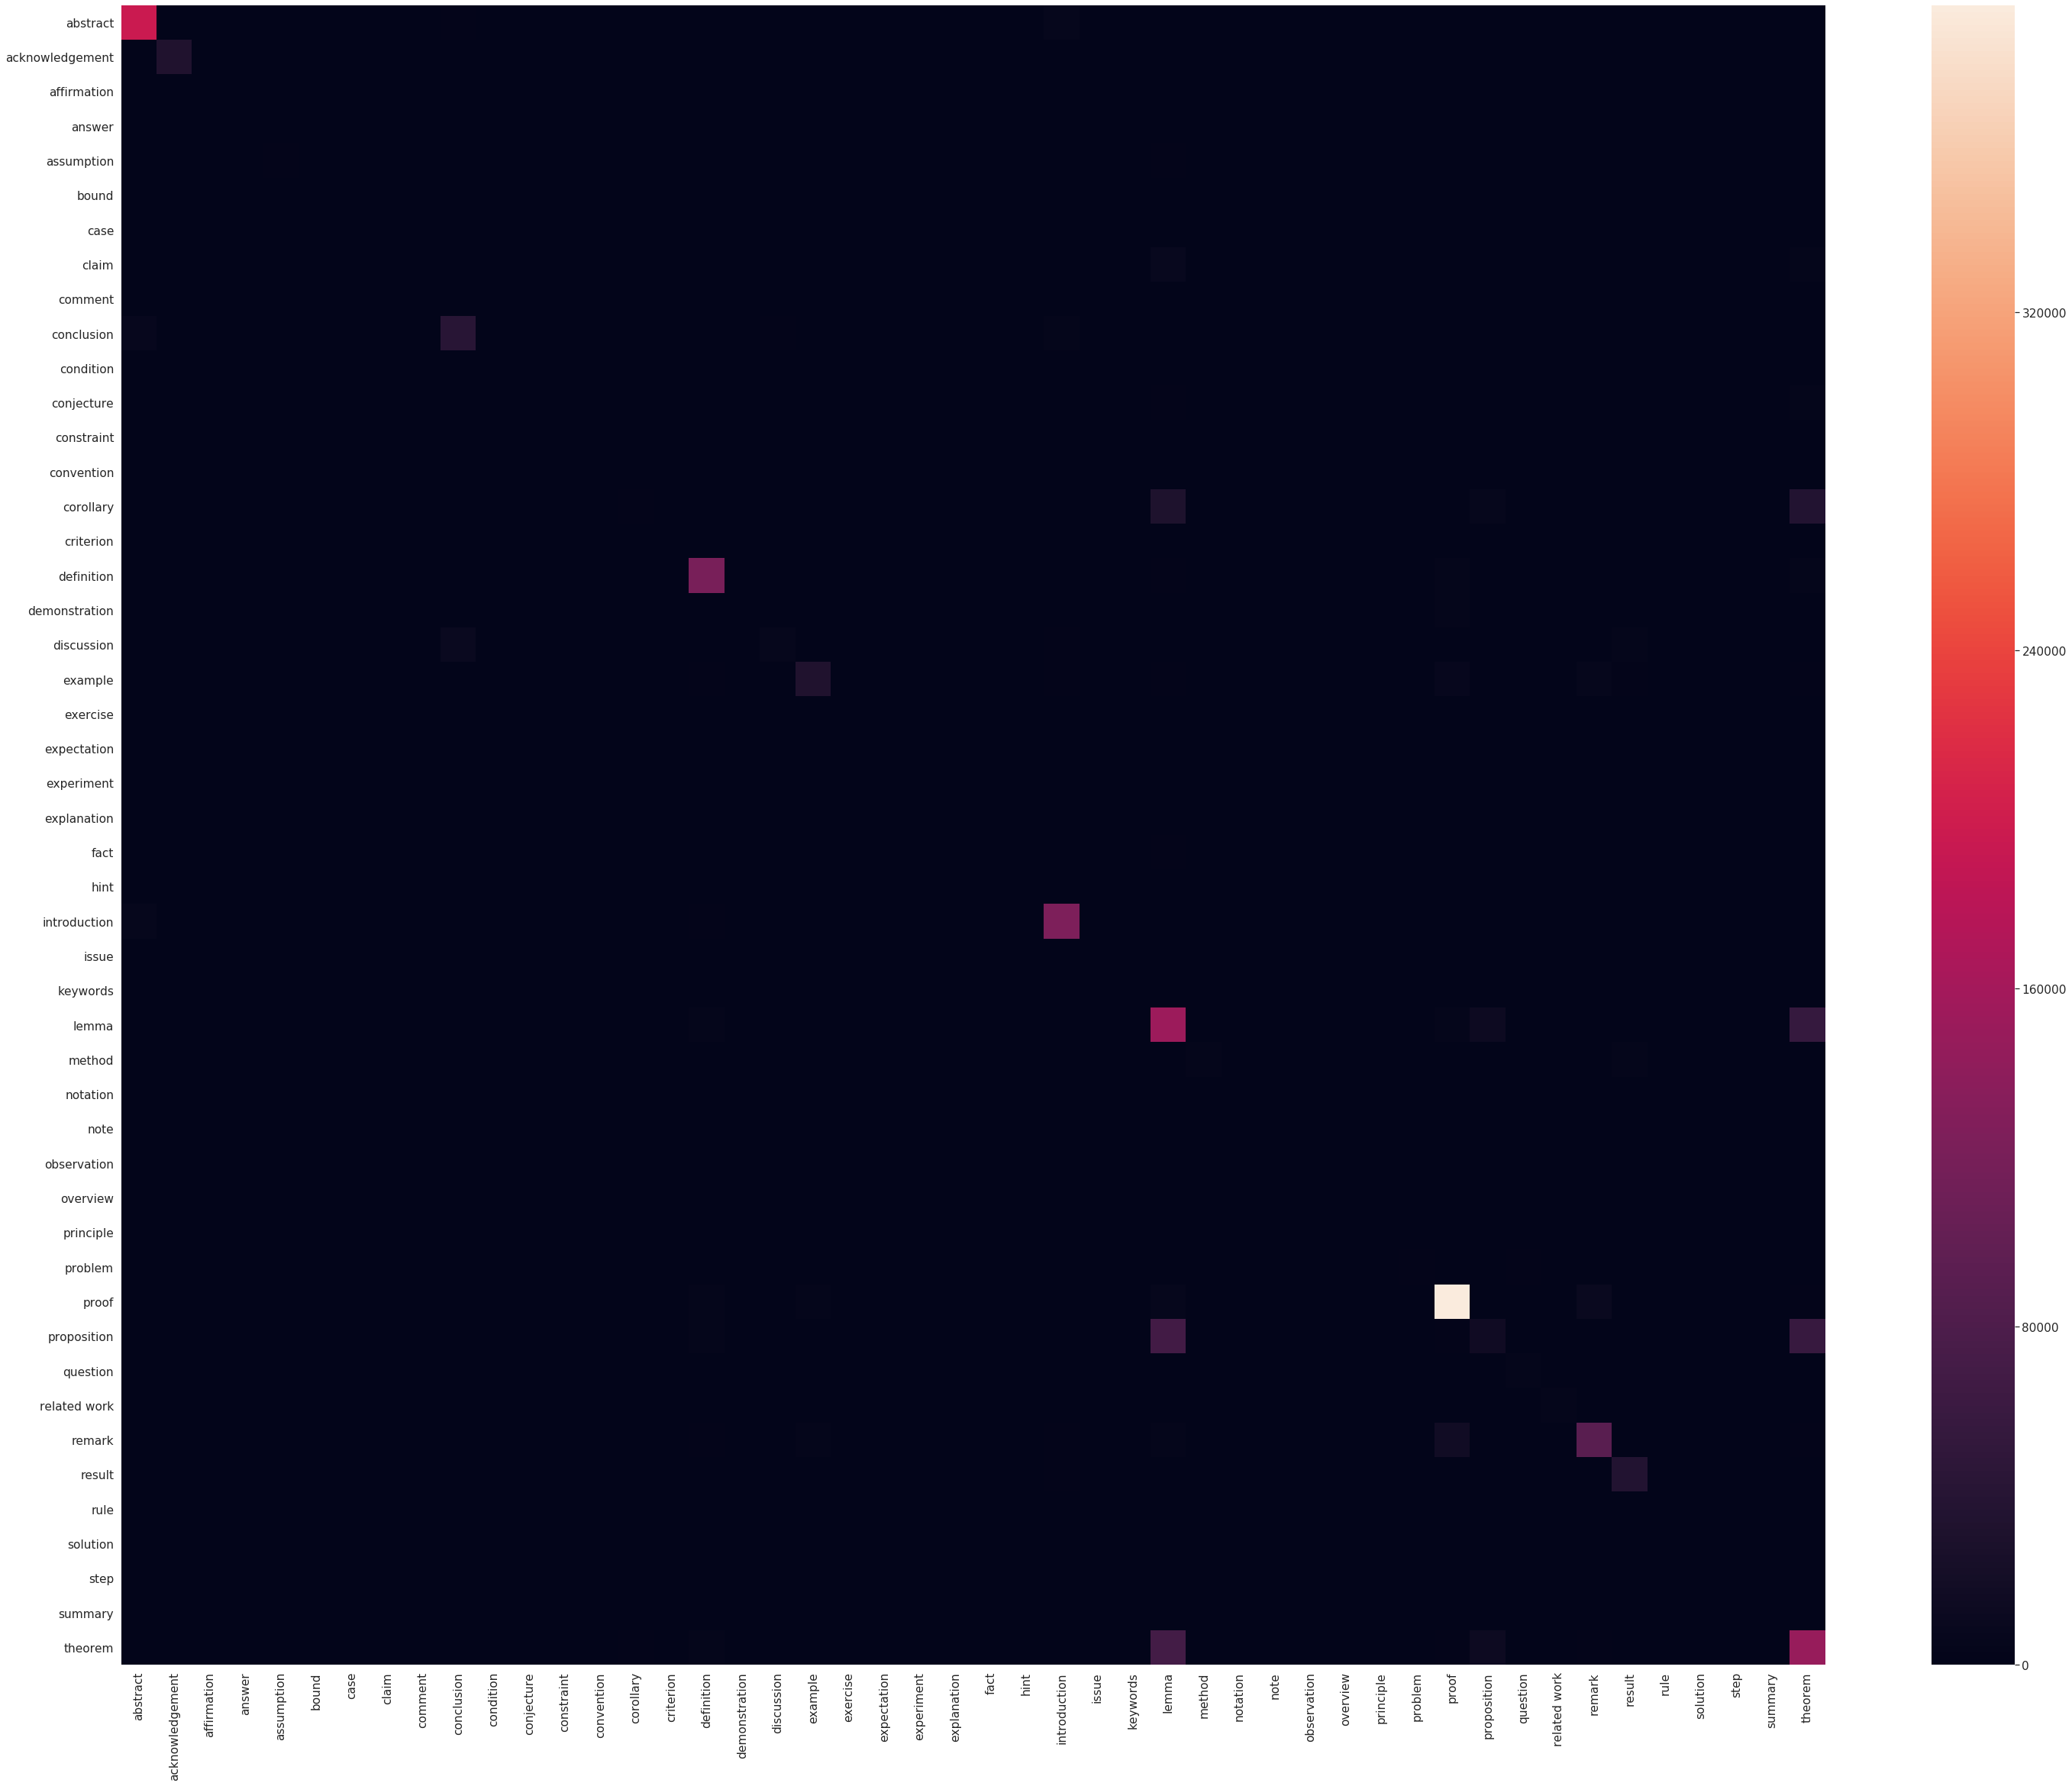

In [15]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(data_hf['y_test'], y_pred, classes=class_names,
                      title='Confusion matrix, without normalization (NOMATH)')

Normalized confusion matrix


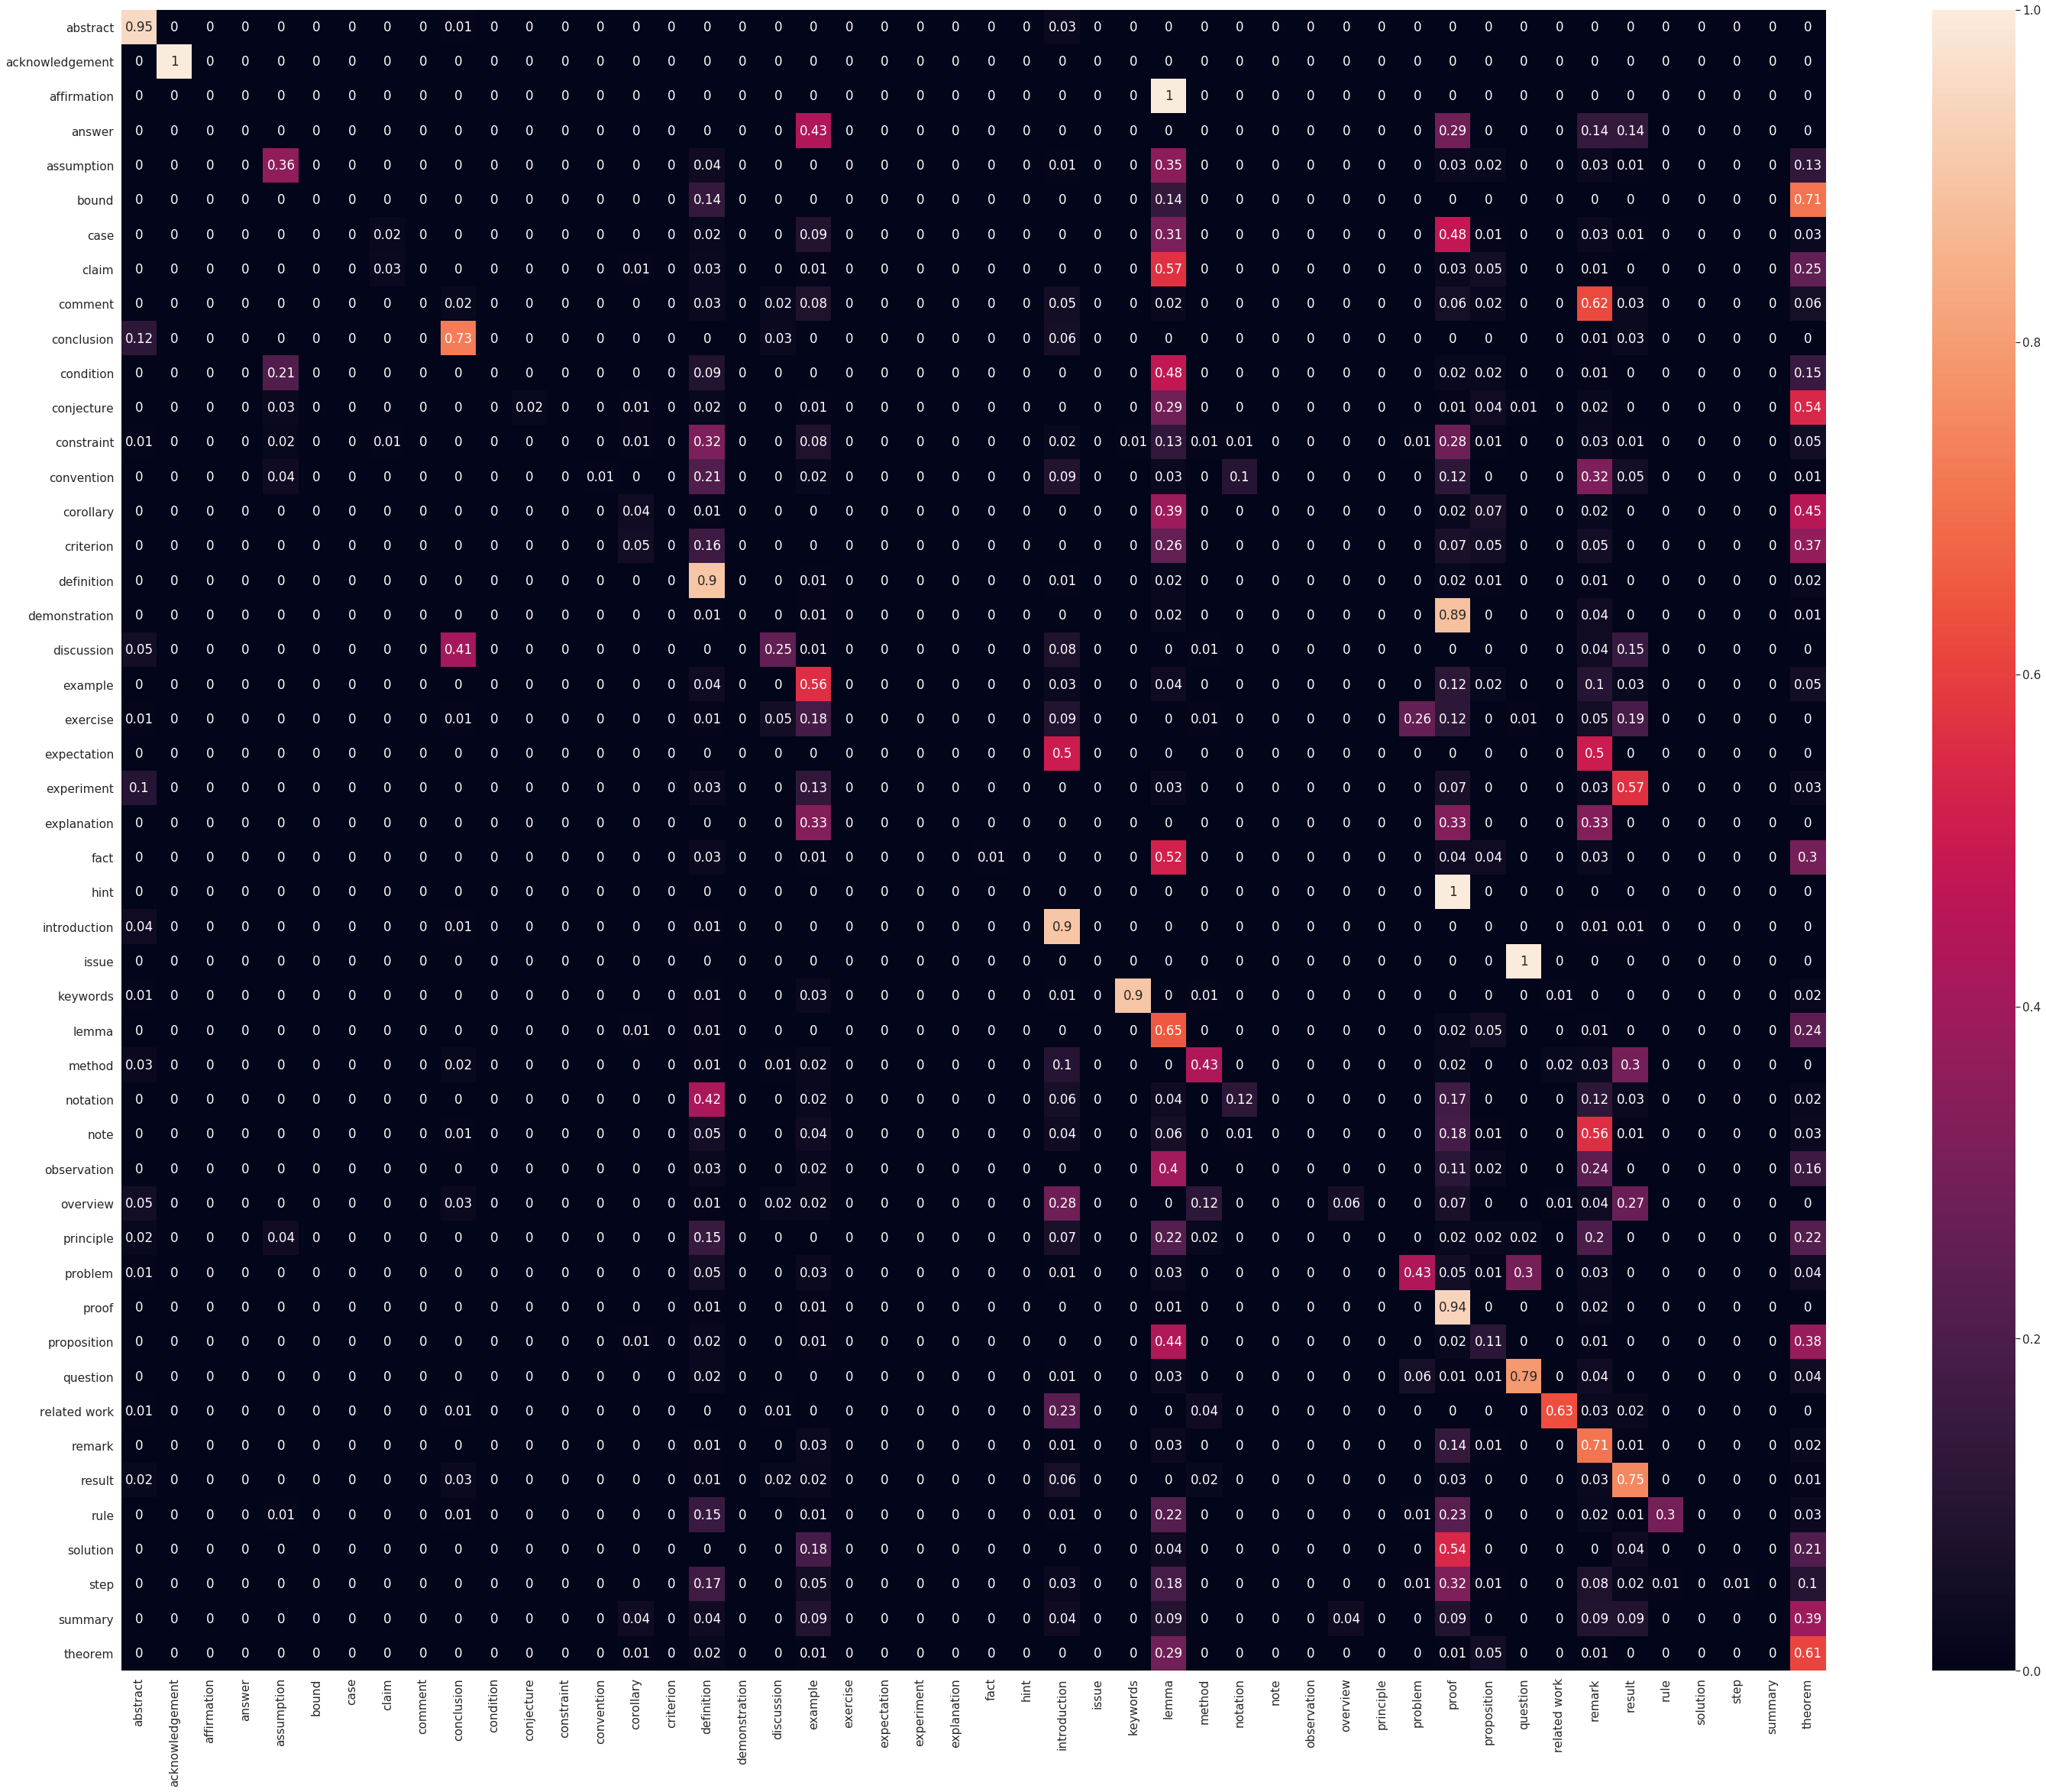

In [16]:
# Plot normalized confusion matrix
plot_confusion_matrix(data_hf['y_test'], y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix (NOMATH)')

# Discussion

## Per-class test measures:

Using 8.1 million paragraphs for training (converged in 14 epochs), then testing on 2 million:
```
              precision    recall  f1-score   support

           0       0.92      0.95      0.94    206137
           1       0.99      1.00      0.99     32444
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         7
           4       0.43      0.36      0.39      5378
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00       441
           7       0.39      0.03      0.05     15155
           8       0.00      0.00      0.00        64
           9       0.73      0.73      0.73     56907
          10       0.00      0.00      0.00       701
          11       0.63      0.02      0.03      8355
          12       0.00      0.00      0.00       146
          13       0.18      0.01      0.02       432
          14       0.36      0.04      0.07     80545
          15       0.00      0.00      0.00        43
          16       0.83      0.90      0.86    133559
          17       0.48      0.00      0.00      4568
          18       0.61      0.25      0.36     23328
          19       0.69      0.56      0.62     57800
          20       0.00      0.00      0.00        80
          22       0.00      0.00      0.00         2
          23       0.00      0.00      0.00        30
          24       0.00      0.00      0.00         3
          25       0.47      0.01      0.01      3294
          26       0.00      0.00      0.00         1
          27       0.85      0.90      0.87    137637
          28       0.00      0.00      0.00         5
          29       0.71      0.90      0.79       313
          30       0.43      0.65      0.52    232511
          31       0.62      0.43      0.51     10189
          32       0.34      0.12      0.18      3215
          33       0.00      0.00      0.00       883
          35       0.00      0.00      0.00      3602
          36       0.58      0.06      0.11      2255
          37       0.00      0.00      0.00        46
          38       0.73      0.43      0.54      5844
          39       0.89      0.94      0.91    419328
          40       0.32      0.11      0.16    152653
          41       0.61      0.79      0.69      5334
          42       0.77      0.63      0.69      5259
          43       0.75      0.71      0.73    127036
          44       0.71      0.75      0.73     47927
          45       0.81      0.30      0.44       142
          46       0.00      0.00      0.00        28
          47       1.00      0.01      0.02      1307
          48       0.00      0.00      0.00        23
          49       0.46      0.61      0.52    242407

   micro avg       0.69      0.69      0.69   2027375
   macro avg       0.38      0.28      0.28   2027375
weighted avg       0.68      0.69      0.67   2027375

```

## Confusion Matrix Analysis

Is it matching the math lexeme variant?
Answer: Yes.
